Analysis of the climate variables from ERA5 data

In [7]:
#Import packages
import os
import earthpy as et
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker 
from matplotlib.ticker import MaxNLocator

In [33]:
#Set path to where the data is
CITY_COUNTRY = 'HUAMBO_ANGOLA'     ##this needs to be manually changed to define which city (rest just run)

######################################################################################################
#load in csv of city lons and lats
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT'))
CITY_COUNTRY_lat_lon = pd.read_excel('CITY_COUNTRY_lat_lon.xlsx', index_col=0)
#set the city latitude and longitudes
City_Lat = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['Lat'][0]
City_Lon = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['Lon'][0]
City_name = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['City'][0]
#set the directory
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT', 'ERA5', CITY_COUNTRY))

#file
filename = '{}_2002_2020.nc'.format(CITY_COUNTRY)

#open file
clim_ds = xr.open_dataset(filename)

#bounds to look at
#Area to look at will be the city centre +/- 0.25 degs?
min_lat = City_Lat - 0.25
max_lat = City_Lat + 0.25
min_lon = City_Lon - 0.25
max_lon = City_Lon + 0.25

#add in date column to the variables
clim_ds['date'] = clim_ds['time']

temp_ds = clim_ds.sel(latitude =(clim_ds.latitude > min_lat) & (clim_ds.latitude < max_lat), method = 'nearest')

subset_clim_ds = temp_ds.sel(longitude =(temp_ds.longitude >min_lon) & (temp_ds.longitude < max_lon), method = 'nearest')

#send to dataframe
clim_df = subset_clim_ds.to_dataframe()

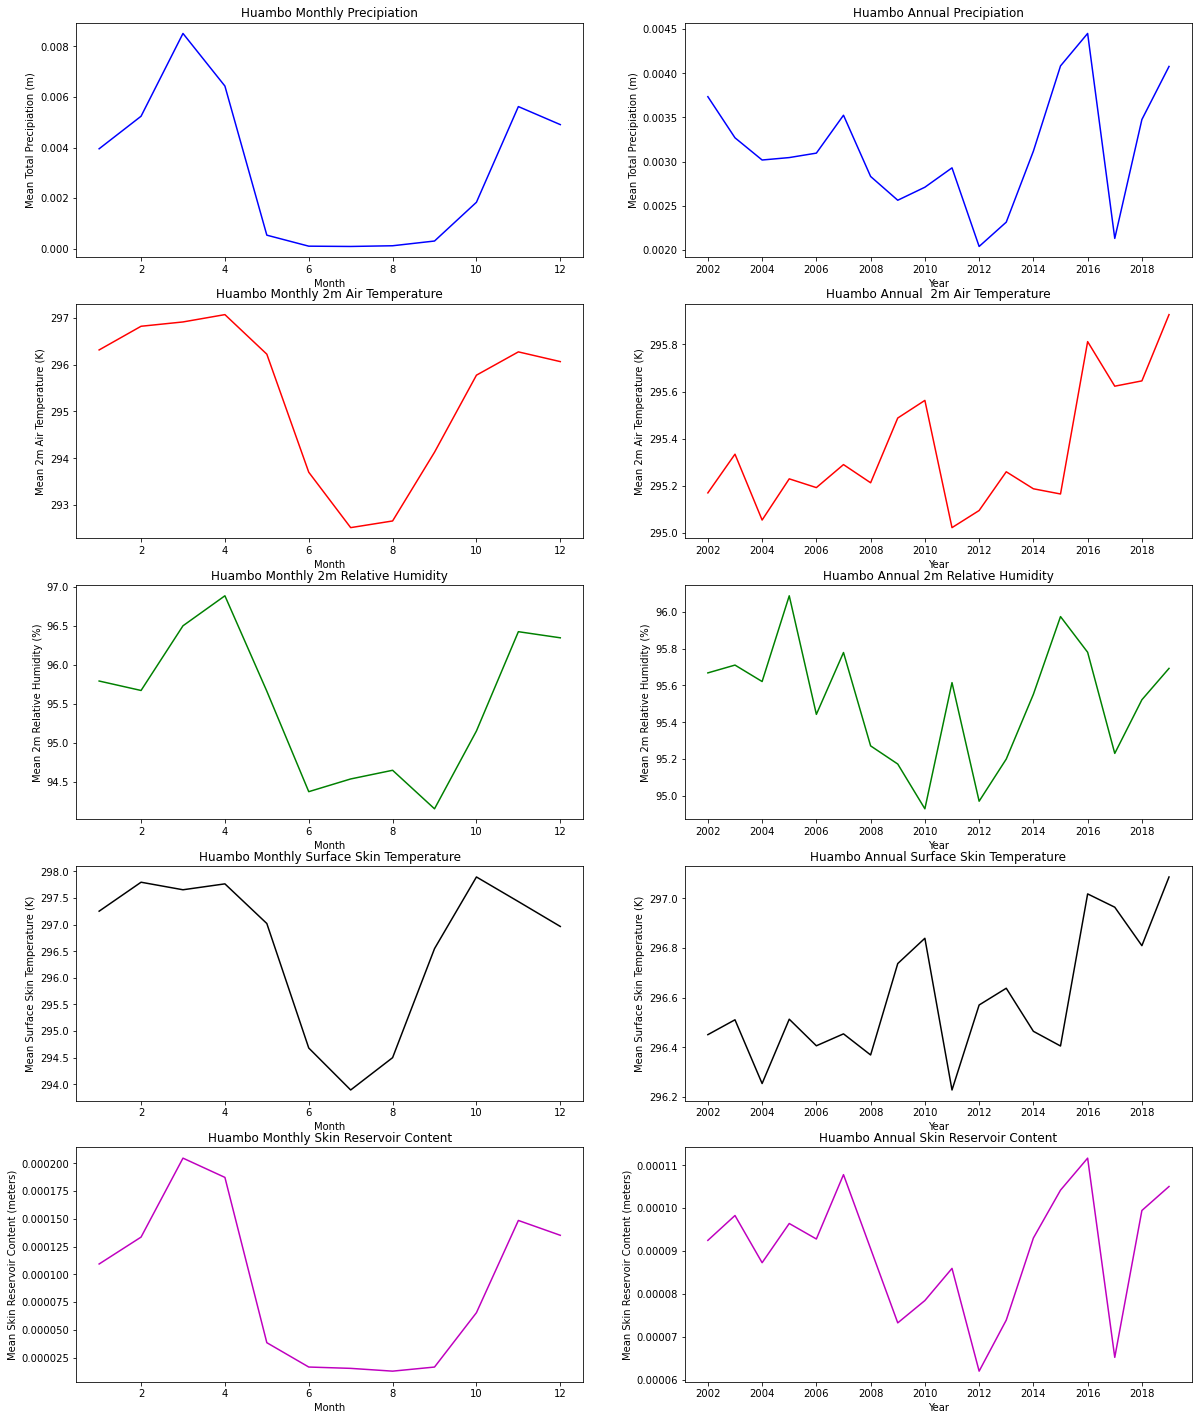

In [34]:
#get averages: precip, 2m air temp
#then plot                         
#Extract the months and years from the date
date2 = pd.DatetimeIndex(clim_df['date'])
clim_df['date2']= date2
clim_df['month'] = date2.month
clim_df['year'] = date2.year

#Add in the relative humidity
def calc_rh(x):
    a = 17.67
    b = 243.5
    rh = 100* np.exp(a*x["d2m"]/(b+x["d2m"]))/ np.exp(a*x["t2m"]/(b+x["t2m"]))
    return rh

clim_df["rh"] = calc_rh(clim_df)

#group by month/ year to get means
g_mon = clim_df.groupby(["month"])
monthly_averages = g_mon.aggregate({"tp":np.mean, "t2m":np.mean, "rh":np.mean, "skt":np.mean, "src":np.mean})

g_yr = clim_df.groupby(["year"])
yearly_averages = g_yr.aggregate({"tp":np.mean, "t2m":np.mean, "rh":np.mean, "skt":np.mean, "src":np.mean})

#remove 2020 from the annual averages as data for Dec 2020 not available. Will skew 2020
yearly_averages.drop(yearly_averages.tail(1).index,inplace=True) # drop last row


#plot monthly and yearly precip, air temp 2m, relative humidity, skin temperature

fig, axes = plt.subplots(nrows = 5,ncols = 2, figsize=(20, 25))

axes[0,0].plot(monthly_averages.tp, 'b')
axes[0,0].set_title('{} Monthly Precipiation'.format(City_name))
axes[0,0].set(xlabel = 'Month', ylabel = 'Mean Total Precipiation (m)')

axes[0,1].plot(yearly_averages.tp, 'b')
axes[0,1].set_title('{} Annual Precipiation'.format(City_name))
axes[0,1].set(xlabel = 'Year', ylabel = 'Mean Total Precipiation (m)')

axes[1,0].plot(monthly_averages.t2m, 'r')
axes[1,0].set_title('{} Monthly 2m Air Temperature'.format(City_name))
axes[1,0].set(xlabel = 'Month', ylabel = 'Mean 2m Air Temperature (K)')

axes[1,1].plot(yearly_averages.t2m, 'r')
axes[1,1].set_title('{} Annual  2m Air Temperature'.format(City_name))
axes[1,1].set(xlabel = 'Year', ylabel = 'Mean 2m Air Temperature (K)')

axes[2,0].plot(monthly_averages.rh, 'g')
axes[2,0].set_title('{} Monthly 2m Relative Humidity'.format(City_name))
axes[2,0].set(xlabel = 'Month', ylabel = 'Mean 2m Relative Humidity (%)')

axes[2,1].plot(yearly_averages.rh, 'g')
axes[2,1].set_title('{} Annual 2m Relative Humidity'.format(City_name))
axes[2,1].set(xlabel = 'Year', ylabel = 'Mean 2m Relative Humidity (%)')

axes[3,0].plot(monthly_averages.skt, 'k')
axes[3,0].set_title('{} Monthly Surface Skin Temperature'.format(City_name))
axes[3,0].set(xlabel = 'Month', ylabel = 'Mean Surface Skin Temperature (K)')

axes[3,1].plot(yearly_averages.skt, 'k')
axes[3,1].set_title('{} Annual Surface Skin Temperature'.format(City_name))
axes[3,1].set(xlabel = 'Year', ylabel = 'Mean Surface Skin Temperature (K)')

axes[4,0].plot(monthly_averages.src, 'm')
axes[4,0].set_title('{} Monthly Skin Reservoir Content'.format(City_name))
axes[4,0].set(xlabel = 'Month', ylabel = 'Mean Skin Reservoir Content (meters)')

axes[4,1].plot(yearly_averages.src, 'm')
axes[4,1].set_title('{} Annual Skin Reservoir Content'.format(City_name))
axes[4,1].set(xlabel = 'Year', ylabel = 'Mean Skin Reservoir Content (meters)')


xa = axes[0,1].get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True)) #make sure the y axis sticks to integers as is by year
xa = axes[1,1].get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True)) 
xa = axes[2,1].get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True)) 
xa = axes[3,1].get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True)) 
xa = axes[4,1].get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True)) 

#save the plot as a png
plt.savefig('era5_clim_trends.png')